In [1]:
import sys
# if not 'mplleaflet' in sys.modules:
#     !pip install mplleaflet
# if not 'numpy-quaternion' in sys.modules:
#     !pip install numpy-quaternion
#Import all of the dependencies we need
import mplleaflet
from tools.FileParser import FileParser as FP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quaternion
from tools.Conversions import RollPitchYaw
from tools.Processing import Processing
#Configure plotting
%matplotlib inline

In [2]:
#Let's make the plots a bit bigger
plt.rcParams['figure.figsize'] = [15, 5]

# Load a file
Using the **Data** menu at the top of the notebook

Data --> Upload

Copy the file link that it returns (e.g. /home/nbuser/vtg_log7_wheel.csv) and put it in the openFile statement below.

In [3]:
data = FP.openFile("Vertigo_Stealth.csv")
#data = FP.openFile("Car_in_a_circle_demo.csv")
#Split out the three datasets
gps = data[0].copy()
imu = data[1].copy()
quat = data[2].copy()

Plot of acceleration in x, y and z

<Axes: xlabel='TimeStamp'>

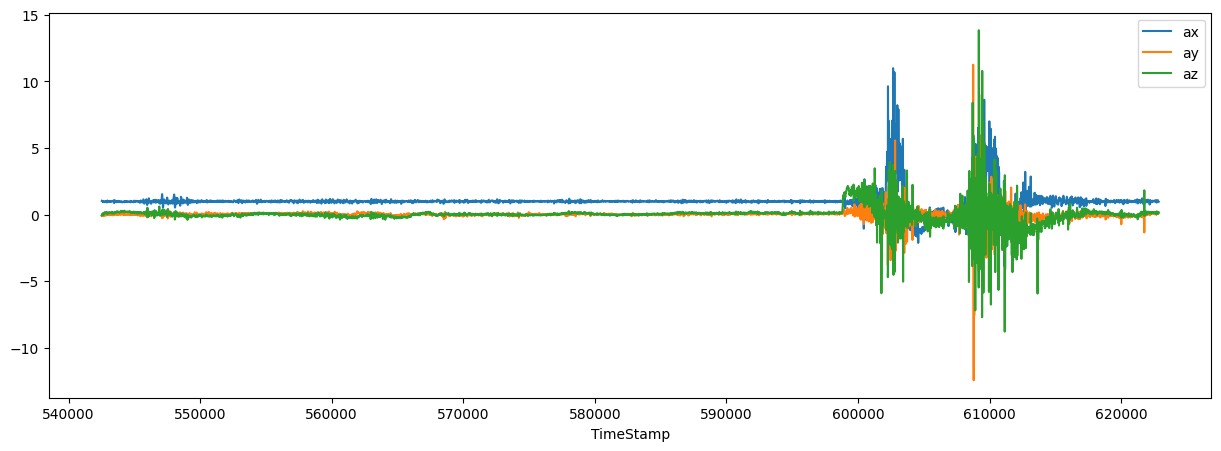

In [4]:
#unsmoothed data
imu.plot(x='TimeStamp',y=['ax','ay','az'])

<Axes: xlabel='TimeStamp'>

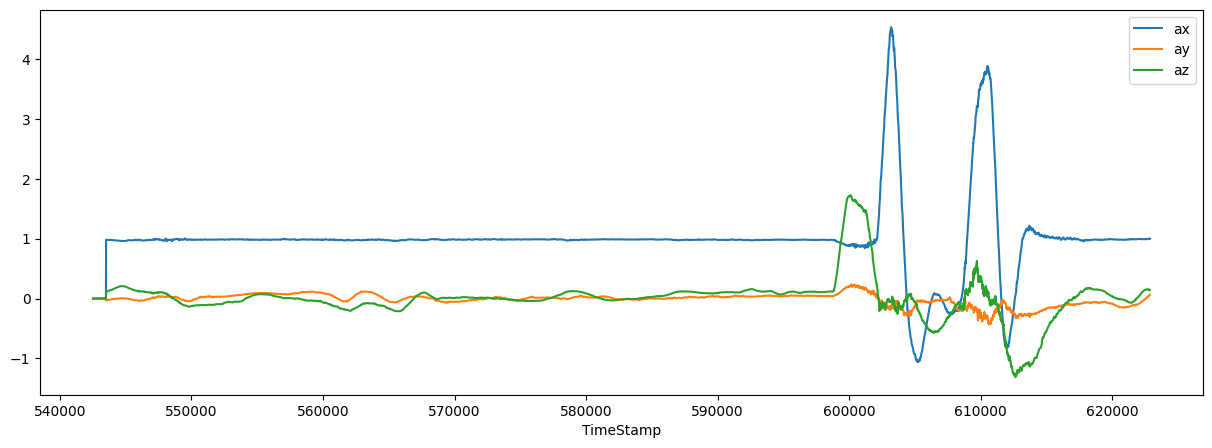

In [5]:
imu_smoothed = imu.copy()
imu_smoothed['ax'] = np.nan_to_num(imu['ax'].rolling(window=100).mean())
imu_smoothed['ay'] = np.nan_to_num(imu['ay'].rolling(window=100).mean())
imu_smoothed['az'] = np.nan_to_num(imu['az'].rolling(window=100).mean())
imu_smoothed.plot(x='TimeStamp',y=['ax','ay','az'])

<Axes: xlabel='TimeStamp'>

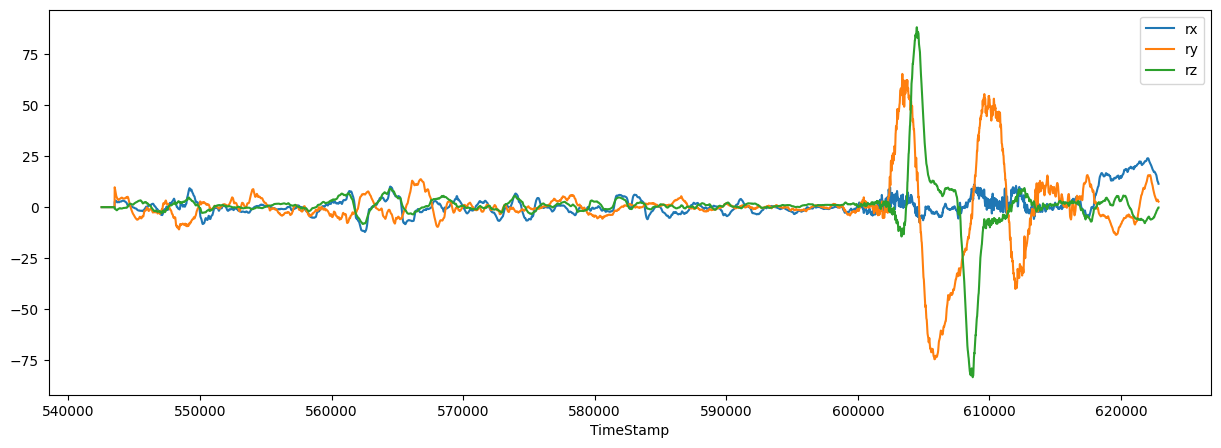

In [6]:
#Smoothed angular velocity
imu_smoothed['rx'] = np.nan_to_num(imu['rx'].rolling(window=100).mean())
imu_smoothed['ry'] = np.nan_to_num(imu['ry'].rolling(window=100).mean())
imu_smoothed['rz'] = np.nan_to_num(imu['rz'].rolling(window=100).mean())
imu_smoothed.plot(x='TimeStamp',y=['rx','ry','rz'])

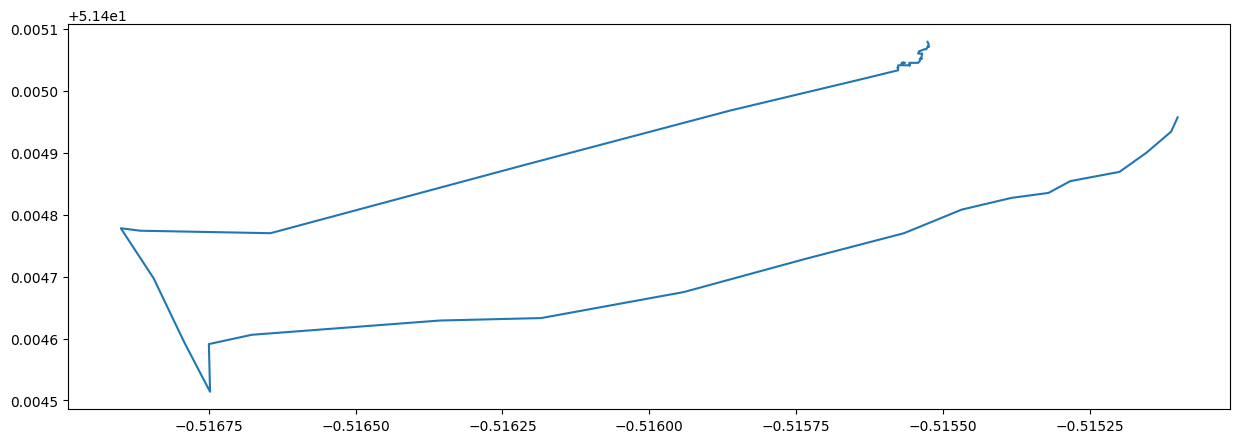

In [7]:
plt.plot(gps['x'], gps['y'])

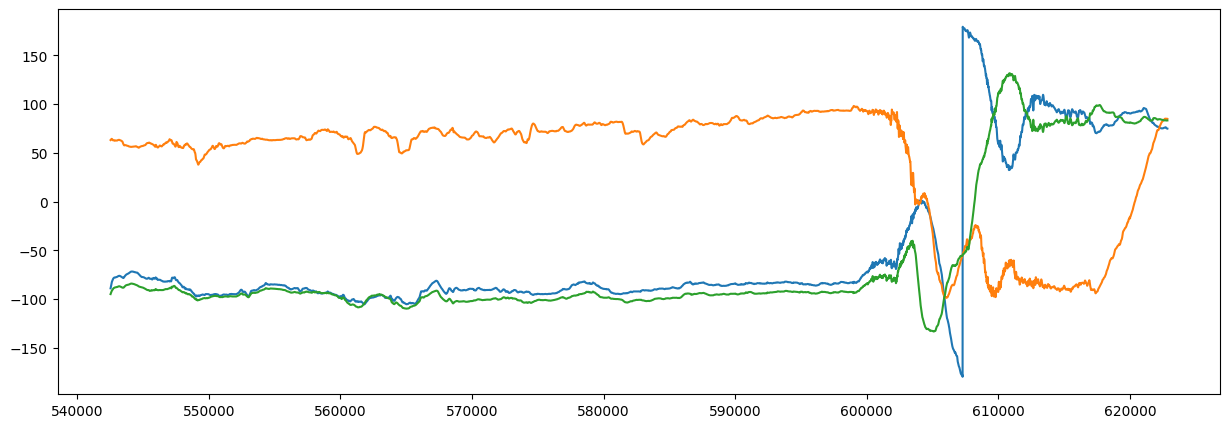

In [8]:
euler = RollPitchYaw.convert(quat.values)
plt.plot(quat['TimeStamp'],euler)

In [9]:
#idx = np.searchsorted(quat['TimeStamp'], imu['TimeStamp']) - 1
#mask = idx >= 0

#quat_matched_imu = pd.DataFrame({
#    "TimeStamp":imu['TimeStamp'].values[mask],
#    "q0":quat['q0'].values[idx][mask],
#    "q1":quat['q1'].values[idx][mask],
#    "q2":quat['q2'].values[idx][mask],
#    "q3":quat['q3'].values[idx][mask],
#    "ax":imu['ax'].values[mask],
#    "ay":imu['ay'].values[mask],
#    "az":imu['az'].values[mask],
#    "rx":imu['rx'].values[mask],
#    "ry":imu['ry'].values[mask],
#    "rz":imu['rz'].values[mask]
#})
quat_matched_imu = Processing.matchIMUtoQuat(imu,quat)
quat_matched_imu_world = quat_matched_imu.copy()

quat_i = np.array([quat_matched_imu['q0'],quat_matched_imu['q1'],quat_matched_imu['q2'],quat_matched_imu['q3']]).T
accel = np.array([quat_matched_imu['ax'],quat_matched_imu['ay'],quat_matched_imu['az']]).T
rot = np.array([quat_matched_imu['rx'],quat_matched_imu['ry'],quat_matched_imu['rz']]).T
#This transform takes a while to calculate on all of the data (a minute or so), be patient while this runs!
accel_world = RollPitchYaw.transform(accel,quat_i)
rot_world = RollPitchYaw.transform(rot,quat_i)
quat_matched_imu_world['ax'] = accel_world[:,0]
quat_matched_imu_world['ay'] = accel_world[:,1]
quat_matched_imu_world['az'] = accel_world[:,2]
quat_matched_imu_world['rx'] = rot_world[:,0]
quat_matched_imu_world['ry'] = rot_world[:,1]
quat_matched_imu_world['rz'] = rot_world[:,2]
    

<Axes: xlabel='TimeStamp'>

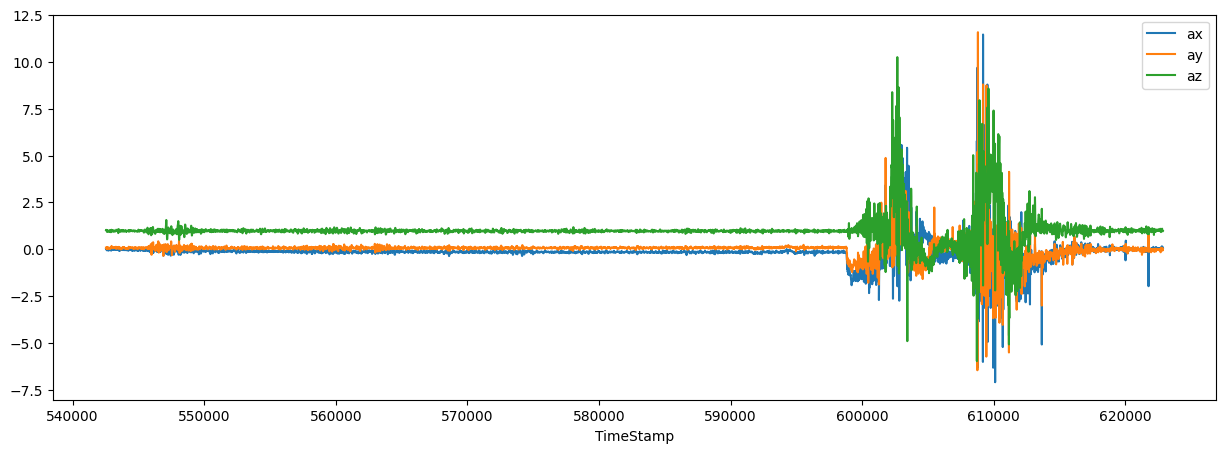

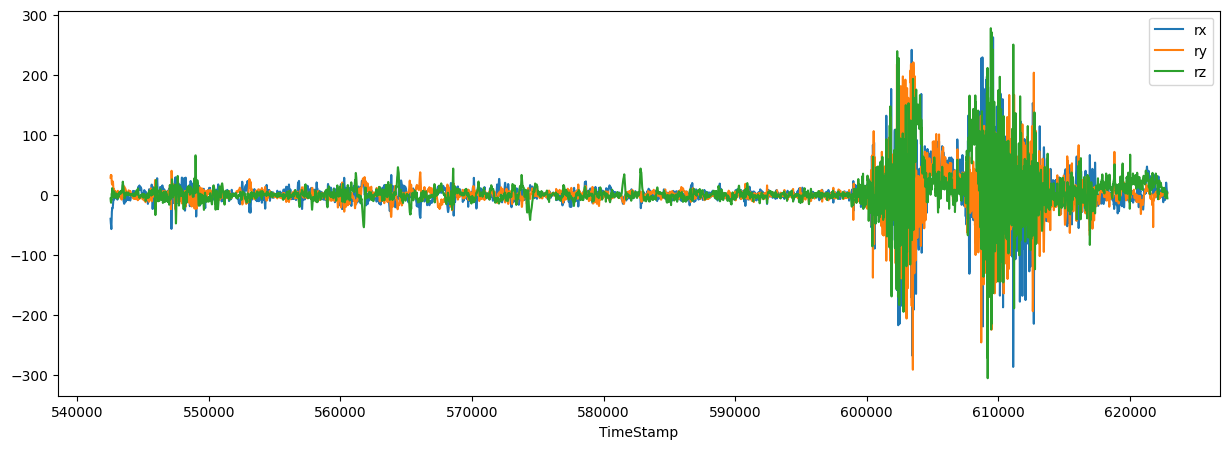

In [10]:
quat_matched_imu_world.plot(x='TimeStamp',y=['ax','ay','az'])
quat_matched_imu_world.plot(x='TimeStamp',y=['rx','ry','rz'])

<Axes: xlabel='TimeStamp'>

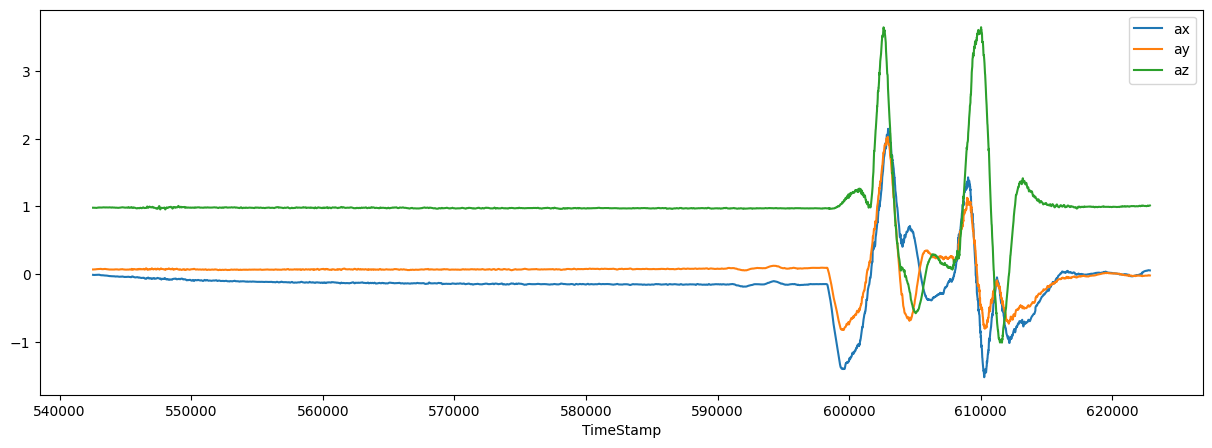

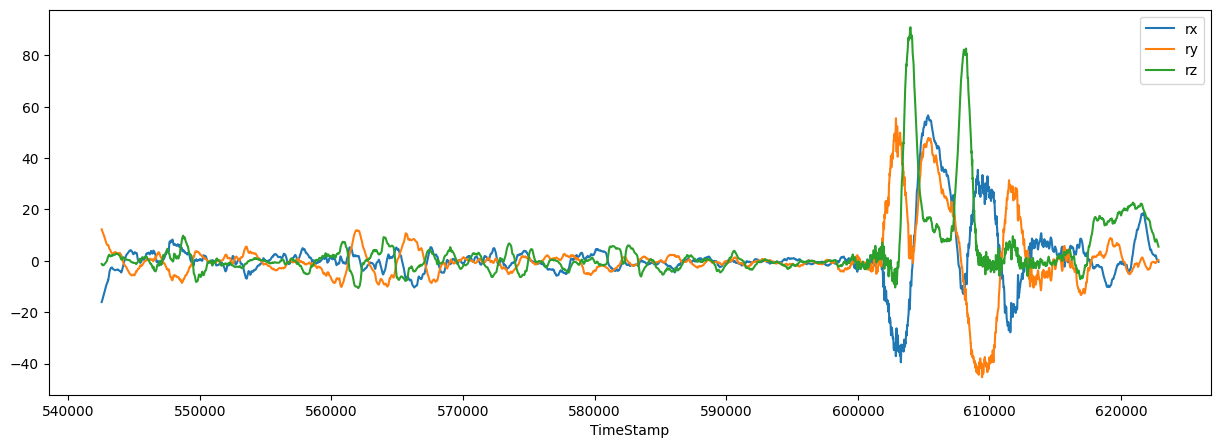

In [11]:
quat_imu_world_smoothed = quat_matched_imu_world.copy()
quat_imu_world_smoothed['ax'] = quat_matched_imu_world['ax'].rolling(window=100,min_periods=0,center=True).mean()
quat_imu_world_smoothed['ay'] = quat_matched_imu_world['ay'].rolling(window=100,min_periods=0,center=True).mean()
quat_imu_world_smoothed['az'] = quat_matched_imu_world['az'].rolling(window=100,min_periods=0,center=True).mean()
quat_imu_world_smoothed['rx'] = quat_matched_imu_world['rx'].rolling(window=100,min_periods=0,center=True).mean()
quat_imu_world_smoothed['ry'] = quat_matched_imu_world['ry'].rolling(window=100,min_periods=0,center=True).mean()
quat_imu_world_smoothed['rz'] = quat_matched_imu_world['rz'].rolling(window=100,min_periods=0,center=True).mean()
quat_imu_world_smoothed.plot(x='TimeStamp',y=['ax','ay','az'])
quat_imu_world_smoothed.plot(x='TimeStamp',y=['rx','ry','rz'])

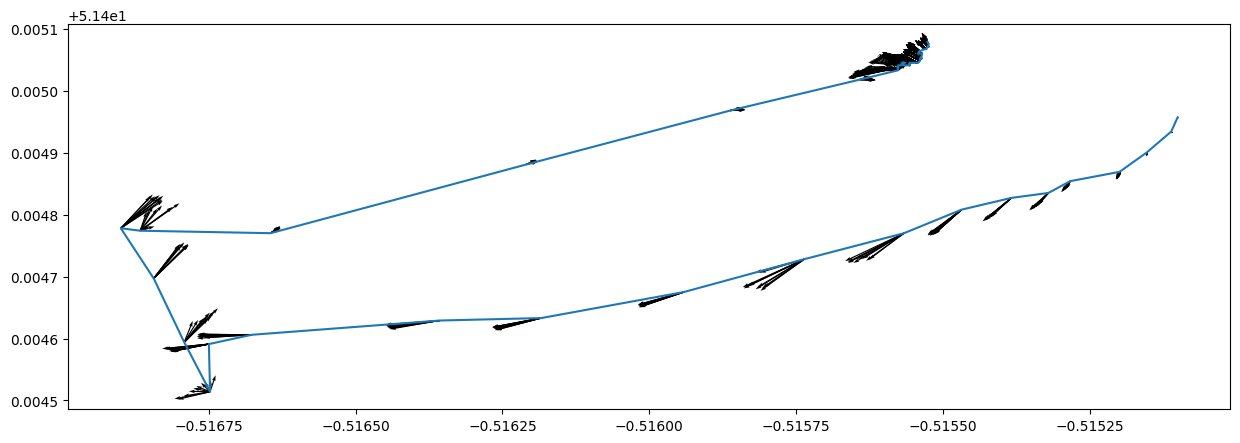

In [12]:
time_sorted_imu_world = Processing.matchIMUtoGPS(quat_matched_imu_world,gps)
#We downsample the data as the full set is hard to render!
quiver_plot_output = time_sorted_imu_world[0::10].copy()
quiver_plot_output['ax'] = quiver_plot_output['ax'].rolling(window=100,min_periods=0,center=True).mean()
quiver_plot_output['ay'] = quiver_plot_output['ay'].rolling(window=100,min_periods=0,center=True).mean()
plt.quiver(quiver_plot_output['x'], quiver_plot_output['y'],quiver_plot_output['ax'], quiver_plot_output['ay'], width=0.001)
plt.plot(gps['x'], gps['y'])

In [24]:
from tools.Kalman3d import Kalman3d
%load_ext autoreload
%autoreload 2
filter = Kalman3d(
    quat_matched_imu_world['TimeStamp']/1000,
    quat_matched_imu_world['ay'],
    quat_matched_imu_world['ax'],
    quat_matched_imu_world['az'],
    gps['TimeStamp']/1000,
    gps['y'],
    gps['x'],
    gps['z']
)
filter.process()
(north,east,down,north_vel,east_vel,down_vel,north_accel,east_accel,down_accel) = filter.result()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


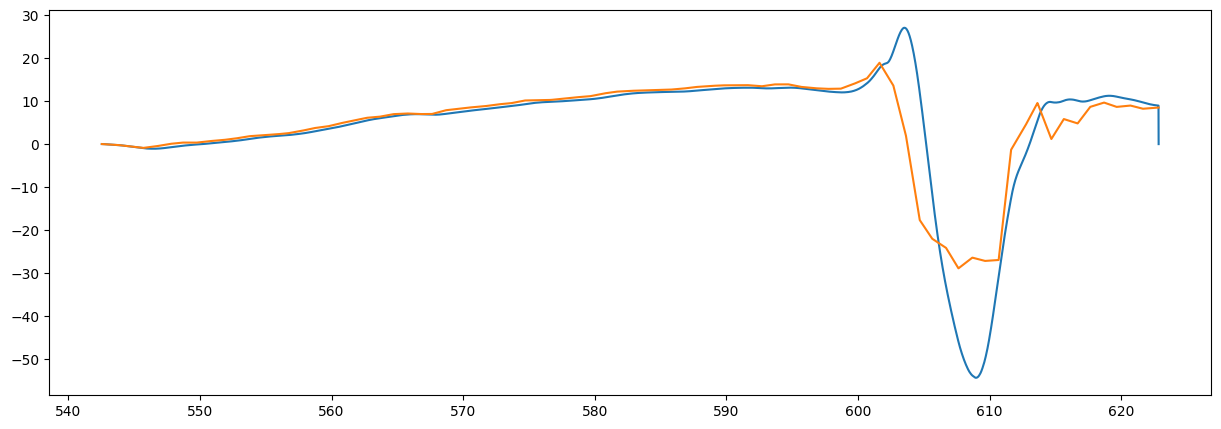

In [25]:
#Stealth is 62 m in height
plt.plot(filter.imutime,down)
plt.plot(filter.imutime,filter.alt_relative)

In [26]:
import plotly.express as px
import utm

easts = np.append(east,filter.eastings)+filter.datum[0][0]
norths = np.append(north,filter.northings)+filter.datum[1][0]
cat = np.append(["kalman" for x in range(len(north))],["gps" for x in range(len(filter.northings))])
coords = utm.to_latlon(easts, norths, filter.datum[2], filter.datum[3]) 
print(coords[1])
fig = px.line_mapbox(lon=coords[1],lat=coords[0],color=cat,zoom=18)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# plt.plot(east,north)
# plt.plot(filter.eastings,filter.northings)

[-0.515526 -0.515526 -0.515526 ... -0.5151   -0.5151   -0.5151  ]


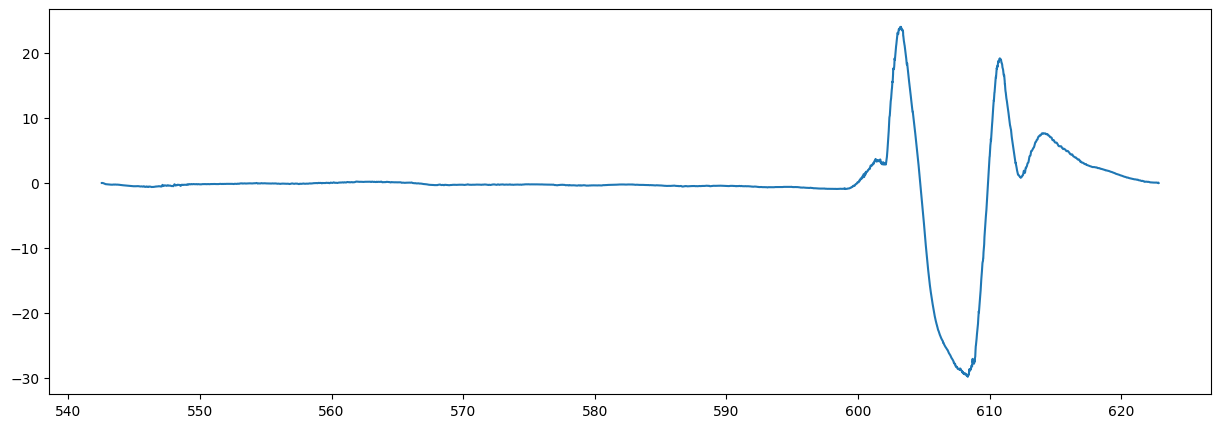

In [16]:
plt.plot(filter.imutime,down_vel)